Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 0.0150 - val_loss: 0.0010
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0011 - val_loss: 7.4153e-04
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 8.0245e-04 - val_loss: 5.3774e-04
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 6.2718e-04 - val_loss: 9.7555e-04
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 5.3965e-04 - val_loss: 0.0020
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 6.1419e-04 - val_loss: 4.5191e-04
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 4.6773e-04 - val_loss: 2.5216e-04
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 4.5228e-04 - val_loss: 3.1641e-04
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 5.3679e-04 - val_loss: 2.1648e-04
Epoch 10/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 4.1625e-04 - val_loss: 2.5555e-04
Prediction range available from 2002-08-19 to 2024-03-13
Enter a dat

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


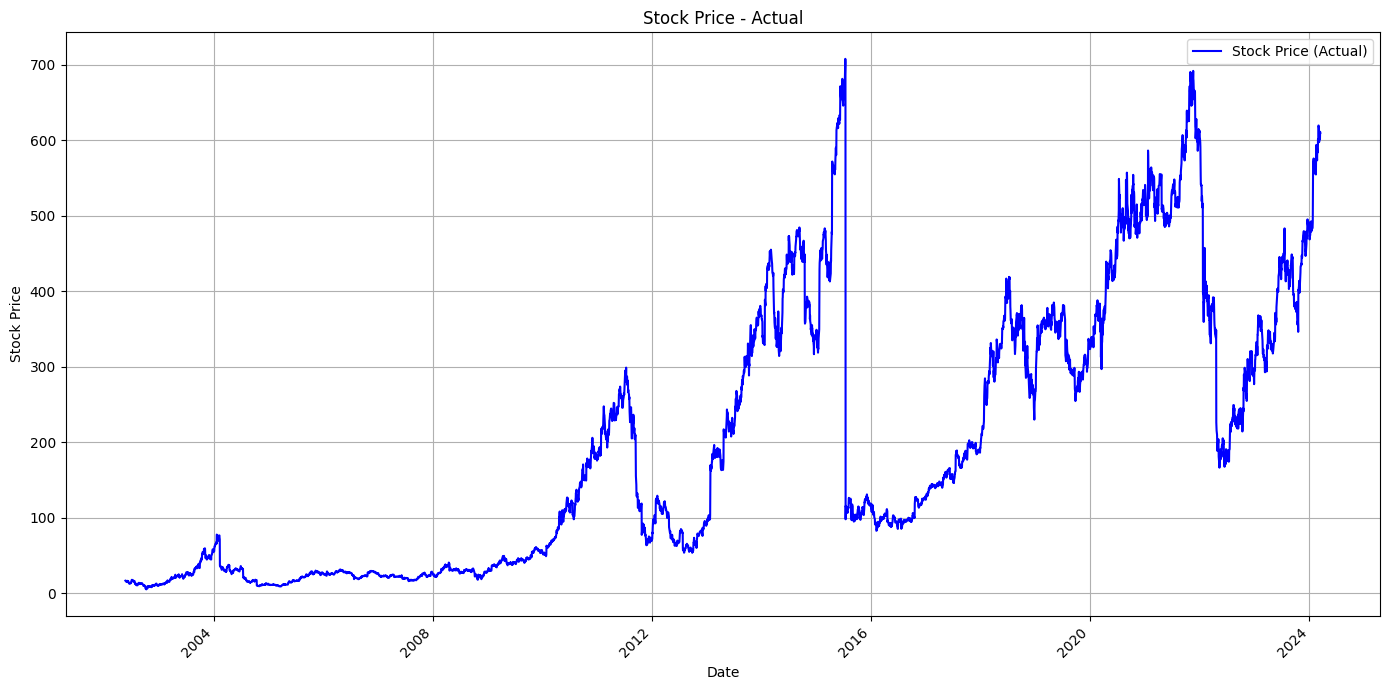

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


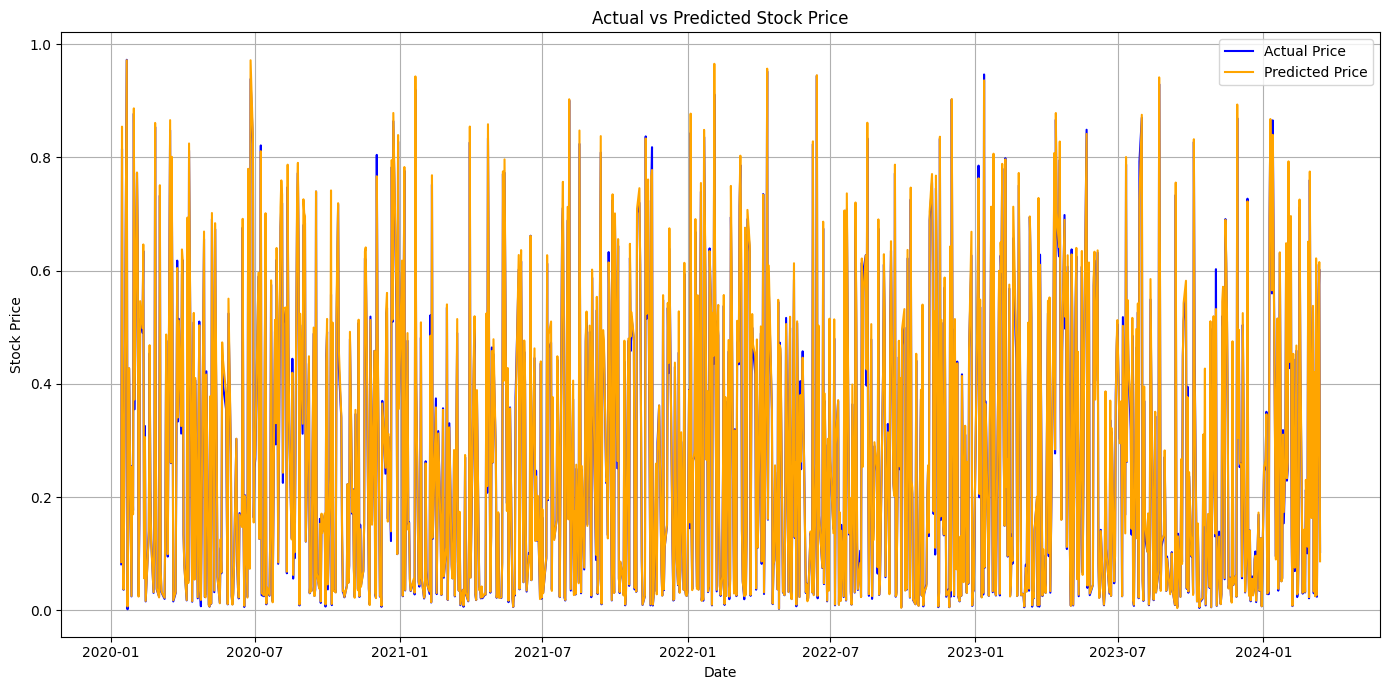

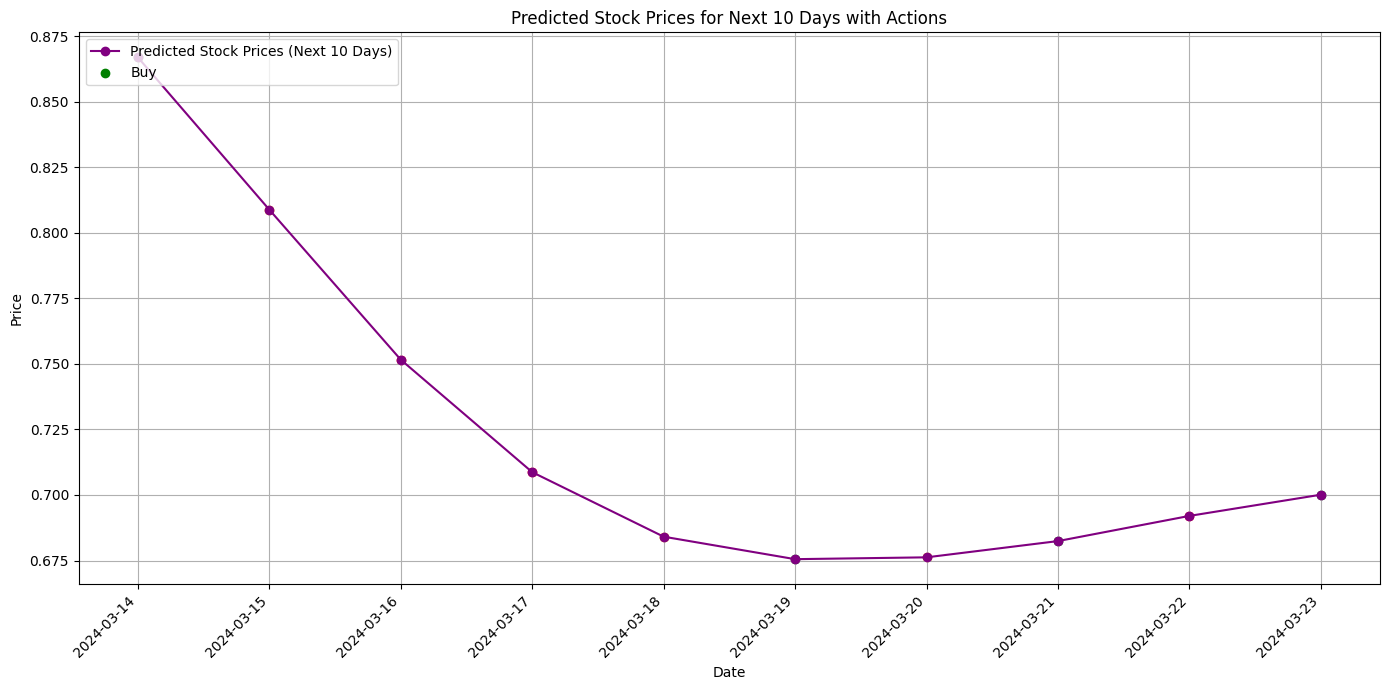

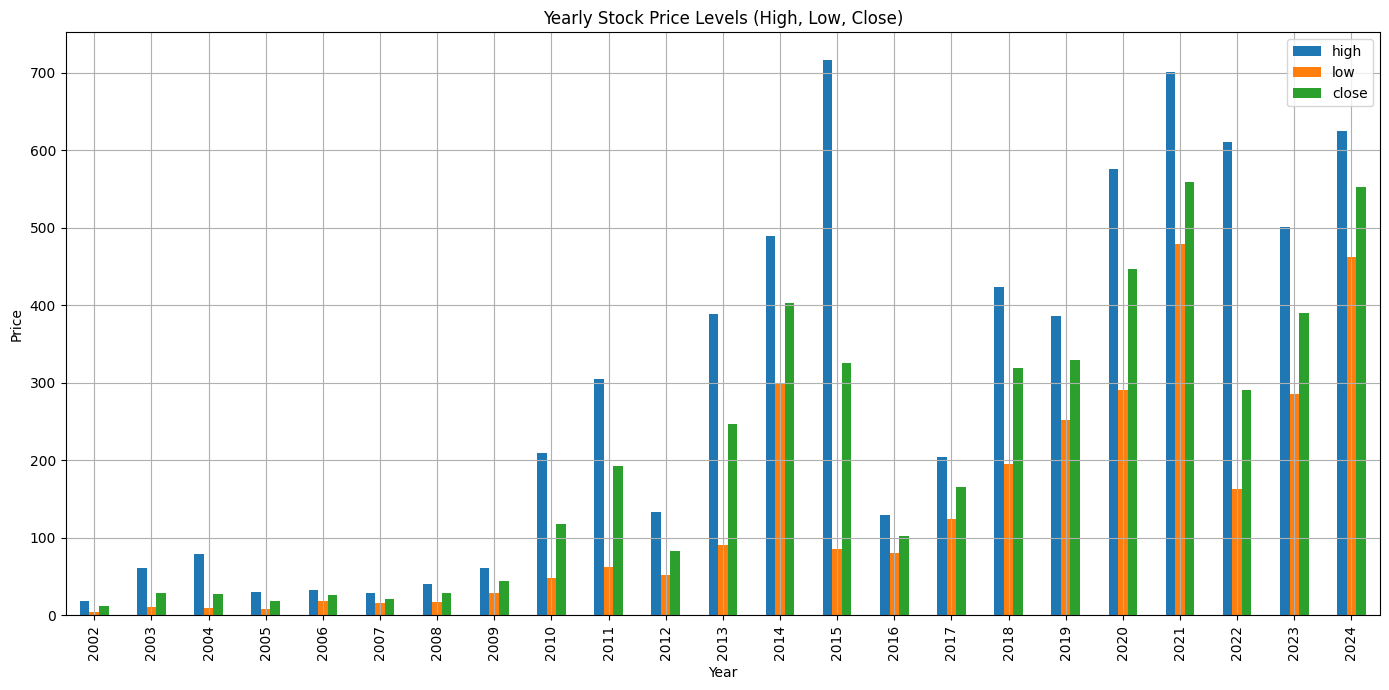

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random

# Load the stock price dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

# Preprocess data: handle missing values and normalize
def preprocess_data(df):
    df = df.dropna()  # Drop any rows with missing values
    df = df[['datetime', 'open', 'high', 'low', 'close']]  # Select relevant columns

    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[['open', 'high', 'low', 'close']])

    return df, df_scaled, scaler

# Build the LSTM model
def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data for LSTM model
def prepare_lstm_data(df_scaled, look_back):
    X, y = [], []
    for i in range(look_back, len(df_scaled)):
        X.append(df_scaled[i - look_back:i, :])  # Get past 'look_back' days
        y.append(df_scaled[i, 3])  # Predict 'close' price
    X, y = np.array(X), np.array(y)
    return X, y

# Train the LSTM model
def train_lstm_model(df, df_scaled, look_back):
    X, y = prepare_lstm_data(df_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    return model, X_test, y_test, df, X_train, y_train

# Use the LSTM model to predict future stock prices
def predict_lstm(model, X_test):
    return model.predict(X_test)

# Predict for a specific date based on the user's input
def predict_for_date(model, recent_data):
    return model.predict(recent_data.reshape(1, recent_data.shape[0], recent_data.shape[1]))[0][0]

# Determine action (Buy, Sell, Hold) based on predicted price change
def determine_action(predicted_value, current_price, threshold=0.02):
    if predicted_value > (current_price * (1 + threshold)):
        return "Buy"
    elif predicted_value < (current_price * (1 - threshold)):
        return "Sell"
    else:
        return "Hold"

# Simple RL agent for stock trading actions
class RLTradingAgent:
    def __init__(self, state_size, action_space=3):
        self.state_size = state_size
        self.action_space = action_space  # Buy, Sell, Hold
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(self.state_size,)),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_space, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size=16):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main program
def main():
    file_path = '/content/NFLX.csv'  # Update this to your file location
    df = load_data(file_path)

    # Preprocess data
    raw_data, data, scaler = preprocess_data(df)

    # Train the LSTM model
    look_back = 60
    lstm_model, X_test, y_test, df, X_train, y_train = train_lstm_model(raw_data, data, look_back)

    # Set prediction range and input date
    prediction_start_date = df['datetime'].iloc[look_back]
    prediction_end_date = df['datetime'].iloc[-1]
    print(f"Prediction range available from {prediction_start_date.date()} to {prediction_end_date.date()}")

    # User input for a specific date
    input_date = input(f"Enter a date within the range ({prediction_start_date.date()} to {prediction_end_date.date()}): ")
    input_date = pd.to_datetime(input_date)
    if not (prediction_start_date <= input_date <= prediction_end_date):
        print("Date is out of prediction range.")
        return

    # Find the index for the input date in the data
    input_idx = df[df['datetime'] == input_date].index[0]

    # Prepare the recent data (look_back days before the input date)
    recent_data = data[input_idx - look_back:input_idx]

    # Predict the stock price for the input date
    predicted_price = predict_for_date(lstm_model, recent_data)
    last_price = raw_data['close'].iloc[input_idx - 1]

    # Determine the action (Buy, Sell, Hold) based on the predicted price
    action = determine_action(predicted_price, last_price)
    print(f"Predicted price for {input_date.date()}: {predicted_price}")
    print(f"Action for {input_date.date()}: {action}")

    # Initialize the RL agent and predict actions for the next 10 days
    rl_agent = RLTradingAgent(state_size=look_back)
    future_dates = pd.date_range(start=input_date, periods=11, freq='D')[1:]
    future_predictions = []
    future_actions = []

    # Make predictions for the next 10 days
    for i in range(10):
        predicted_price = predict_for_date(lstm_model, recent_data)
        future_predictions.append(predicted_price)

        action = rl_agent.act(recent_data.reshape(1, look_back, data.shape[1]))
        future_actions.append(["Hold", "Buy", "Sell"][action])

        # Prepare data for next prediction
        recent_data = np.roll(recent_data, -1, axis=0)
        recent_data[-1, 3] = predicted_price  # Update the recent data with predicted value

    # Plot Actual Stock Price for the dataset
    plt.figure(figsize=(14, 7))
    plt.plot(df['datetime'], df['close'], label='Stock Price (Actual)', color='blue')
    plt.title('Stock Price - Actual')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Plot Actual vs Predicted Prices for the test dataset
    predicted_prices = predict_lstm(lstm_model, X_test)
    plt.figure(figsize=(14, 7))
    plt.plot(df['datetime'][-len(y_test):], y_test, label='Actual Price', color='blue')
    plt.plot(df['datetime'][-len(predicted_prices):], predicted_prices, label='Predicted Price', color='orange')
    plt.title('Actual vs Predicted Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Plot line chart for the next 10 days' predictions with actions
    plt.figure(figsize=(14, 7))
    plt.plot(future_dates, future_predictions, label="Predicted Stock Prices (Next 10 Days)", color='purple', marker='o')

    # Add actions (Buy, Sell, Hold) as markers with different colors
    for i in range(10):
        if future_actions[i] == "Buy":
            plt.scatter(future_dates[i], future_predictions[i], color='green', label='Buy' if i == 0 else "")
        elif future_actions[i] == "Sell":
            plt.scatter(future_dates[i], future_predictions[i], color='red', label='Sell' if i == 0 else "")
        else:
            plt.scatter(future_dates[i], future_predictions[i], color='orange', label='Hold' if i == 0 else "")

    # Adding title and labels
    plt.title('Predicted Stock Prices for Next 10 Days with Actions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.show()

    # Yearly Stock Price Levels (High, Low, Close)
    df['year'] = df['datetime'].dt.year
    yearly_data = df.groupby('year').agg({'high': 'max', 'low': 'min', 'close': 'mean'})
    yearly_data.plot(kind='bar', figsize=(14, 7))
    plt.title('Yearly Stock Price Levels (High, Low, Close)')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
